# Things to consider regarding our modelling in this project:

This project uses plotly, which gives interactive graphs that will not show on github! You must pull this and open it in a code editor such as vscode to see the majority of plots. You do not need to run the project, simply pull it. You can also see it with the link to deepnote. Where everything renders correctly.



# Blockchain project #2: Uncle miner
This file will be our only file for this project. 

In this project we have three main tasks. 

### Tasks: 
- model a blockchain that uses uncle and uncle rewards
- model a rewarding mechanism to reward uncle block creators
- model selfish mining (only one attacker) in this blockchain

And we shall try to answer these three questions.

### Answer the following questions: 
- How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles


*** 

- What is the impact of the uncles on selfish mining? Is selfish mining more profitable with uncles?


***

- What does it mean in this model for the selfish mining attack to be profitable?

### Addition:
We expanded the project a bit by creating an uncleminer class to figure out how he would compare against the other miners. In addition we wanted to run the simulation with wrong values to see how this would affect fairness and the blokchain as a whole.

# Fairness
In order to gain some sense of basis of comparison we developed our own fairness algorithm, and altough a bit basic we hope this will grant us a bit of perspective when comparing different modules. 

We choose to define Fairness for a spesific miner as the relationship between Reward over Contribution.
 $$
   Fairness = \frac{Reward}{Contribution} 
$$  

Where Reward is the fraction of the miners reward over total rewards.
 $$
   Reward = \frac{My Reward}{Total Reward} 
$$  
And Contribution is the fraction over My Hashpower over total Hashpower in the system.
$$
   Contribution = \frac{My Hashpower}{Total Hashpower}
$$  


This is used as the fairness for a spesific miner.

This means that a Fairness value of 1 says that it is perfectly fair and you got the percentage you put in. A Fairness value > 1 indicates that you got more than you should have, and a Fairness value < 1 indicates that you got less. 

 In order to gain the fairness of the entire system we will use the median and the standard deviation, in addition to the extremes. The median is the middle number in the sorted fairness list and is more descriptive of Fairness in the data set set than the average. However the average also tells us about how much mining power is wasted. As the average should be 1 if all mining power is used. But forks will decrease this number as you don't get the full reward sum for your effort. We often use the Median to prevent ouliers skew the system. But as the outliers probably are Big miners, selfish miners and uncle miners we want these values as well. The standard deviation should also give us a good view on the fairness as we get a good picture on how the fairness is dispersed. 

 In order to visualize the farirness distribution we use plotly's histograms.


We start off with declearing block, miner and the blockchain:

In [ ]:
#import statements
from IPython.display import HTML, display
import hashlib as hasher
import random
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import statistics

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.decode()
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range(0, len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block: 
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0, "0")
            self.height = 0
            
        else: 
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []
    
    def hash_block(self):
        return hashbits(self.data+self.creator.name+self.previous_hash+str(self.nonce))

    def print(self):
        print(self.data+" "+self.creator.name+" "+str(self.height))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.forked = []
        self.mainchain = []
        self.mainchainPrint = []
        self.uncles = []
        self.uncleBlocks = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
    
    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        r = random.choices(maxes, k=1)
        return r[0]
    
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size += 1

    def print(self):
        for block in self.chain:
            block.print()
            print("______")

    def hasFork(self): #This checks if the chain has a fork        
        for block1 in self.chain:
            for block2 in self.chain:
                if block1 != block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last != None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count

    def createMainChain(self):
        lb = self.longestChain()
        while lb.previous != None or lb.height ==0:
            self.mainchain.append(lb)
            self.mainchainPrint.append(lb.creator.name)
            if lb.height == 0:
                break
            lb = lb.previous
 
    def getUncles(self): #Append blocks that are not in mainchain to uncle list
        for block in self.chain:
            if block not in self.mainchain:
                self.uncles.append(block.creator.name)
    def getUnclesBlock(self):
        for block in self.chain:
            if block not in self.mainchain:
                self.uncleBlocks.append(block)
   
def bitToHex(bitBlock):
    return hex(int(bitBlock,2))

class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.reward = 0 # added reward attribute
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.MinedLastBlock = False
        self.blockchain = blockchain
        self.fairness = None
        self.coins = []
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()

    
    def UpdateLast(self):
        latest = self.blockchain.longestChain()             
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
         
    
    def PoWSolver(self):
        for i in range(0, self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
                self.MinedLastBlock = True
            self.nonce += 1

    



## Visualization + Helper Code
Here are functions we make use of to help represent and visualize the system.

In [ ]:
# a simple function calculating base rewards not worrying about uncle
def calculateBaseRewards(miners, mainchain):
  for minerName in mainchain:
    for miner in miners: 
      if miner.name == minerName:
        miner.reward += BASEREWARD
      miner.coins.append(miner.reward)

# calculating unclerewards
def calculateUncleRewards(miners, bc):
  uncleChain = bc.uncleBlocks
  mainchain = bc.mainchain
  for block in uncleChain:  
    minerName = block.creator.name 
    height = block.height 
    for mainBlock in mainchain:
      if mainBlock.height == height:
        nephewName = mainBlock.creator.name

    for miner in miners: 
      if miner.name == minerName:
        for i in range(height,len(miner.coins)):
          miner.coins[i] += UNCLEREWARD
        miner.reward += UNCLEREWARD
        
      if miner.name == nephewName:
        miner.reward += NEPHEWREWARD
        for i in range(height,len(miner.coins)):
          miner.coins[i] += NEPHEWREWARD

# removing unclerewards
def removeUncleRewards(miners,bc):
  uncleChain = bc.uncleBlocks
  mainchain = bc.mainchain
  for block in uncleChain:  
    minerName = block.creator.name 
    height = block.height 
    for mainBlock in mainchain:
      if mainBlock.height == height:
        nephewName = mainBlock.creator.name

    for miner in miners: 
      if miner.name == minerName:
        for i in range(height,len(miner.coins)):
          miner.coins[i] -= UNCLEREWARD
        miner.reward -= UNCLEREWARD
        
      if miner.name == nephewName:
        miner.reward -= NEPHEWREWARD
        for i in range(height,len(miner.coins)):
          miner.coins[i] -= NEPHEWREWARD


def showRewards(miners):
  for m in miners:
    print(m.name," earned: ", m.reward," coins")

def visualizeRewards(miners, withOrWithout):
  def getReward(elem):
    return elem.reward
  names = []
  coins = []
  nameCoinDict = {}
  miners.sort(key=getReward)
  for m in miners:
    names.append(m.name)
    coins.append(m.reward)
    nameCoinDict[m.name] = m.reward
  plotdata = pd.DataFrame({"coins": coins, "name": names})
  average=  sum(coins)/len(coins)
  
  s = "Coins rewarded "+ withOrWithout+ " uncle reward : "+ str(sum(coins))+" average: " + str(average)  
  #print(plotdata)
  fig = px.bar(x= names, y= coins, title=s, color=coins, labels={"x": "Miners", "y":"Coins rewarded"})
  fig.add_trace(
    go.Scatter(
        x=names,
        y=[average]*len(miners),
        mode="lines",
        line=go.scatter.Line(color="gray"),
        showlegend=False)
)
  fig.show()
    
#Calculate fairness for a spesific miner
def calculateFairness(MyReward, MyHash, TotalReward, TotalHash):
    return (MyReward/TotalReward)/(MyHash/TotalHash)

#Visualize fairness of the entire system
def VisualizeFairnessOfSystem(miners, withorwithout):
    def getFairness(elem):
      return elem.fairness
    fairnessList = []
    totalReward = 0
    totalHash = 0
    names = []
    
    for miner in miners:
      totalReward+= miner.reward
      totalHash += miner.miningPower
      names.append(miner.name)
    for miner in miners:
      miner.fairness = calculateFairness(miner.reward,miner.miningPower,totalReward, totalHash)
    miners.sort(key=getFairness)
    for miner in miners:
      fairnessList.append(miner.fairness)
    std =np.std(fairnessList)
    median = np.median(fairnessList)
    minimum = np.min(fairnessList)
    s = "Reward to effort ratio: " + withorwithout + " unclereward"
    fig = px.bar(x= names, y= fairnessList, title=s, color=fairnessList, labels={"x": "Miners", "y":"Ratio"})
    fig.show()
    
    print("Standard deviation of fairness: ", std)
    print("Median fairness of system: ", median)
    print("Minimum fairness of system: ", minimum)
    print("Maximum fairness of system: ", np.max(fairnessList))
    print("average: ", np.average(fairnessList))
    
#Sets up the blockchain for analysis and calculates base rewards
def prepareBlockchain(blockchain, miners):
  blockchain.createMainChain()
  blockchain.getUncles()
  blockchain.getUnclesBlock()
  calculateBaseRewards(miners,bc.mainchainPrint)


#Plots everything, A bit too large maybe
def analyzeBlockchain(miners, blockchain):
  blockchain.createMainChain()
  blockchain.getUncles()
  blockchain.getUnclesBlock()
  calculateBaseRewards(miners,bc.mainchainPrint)
  print("Rewards given to miners without uncle as well as fairness of the system")
  visualizeRewards(miners, "without")
  VisualizeFairnessOfSystem(miners, "without")
  PercentageOfForks(bc)
  print("Plotting all miners against eachother without unclereward")
  plotAllMinersOverTime(miners)
  print("visualizes average miners vs deviant miners without unclereward")
  plotAverageMiners(miners)
  calculateUncleRewards(miners, bc)
  print("Plotting all miners against eachother with unclereward")
  plotAllMinersOverTime(miners)
  print("visualizes average miners vs deviant miners with unclereward")
  plotAverageMiners(miners)
  visualizeRewards(miners, "with")
  VisualizeFairnessOfSystem(miners, "with")
  print("percentage of forks: ", PercentageOfForks(bc))
  
#Plots all miners against eachother
def plotAllMinersOverTime(miners):
  allCoins = []
  minername = []
  for m in miners: 
    allCoins.append(m.coins)
    minername.append(m.name)
  i = 0
  for wallet in allCoins: 
    currentName = minername[i]
    i += 1

    plt.plot(wallet, label=currentName)
    plt.xlabel("Nr of blocks mined")
    plt.ylabel("coins")
    plt.title("Evolution of coins")
    
  plt.legend()
  plt.show()
#visualizes average miners and deviant miners
def plotAverageMiners(miners):
  averageMiner =[]
  otherminers = []
  bigminer = []
  selfishMiner = []
  uncleMiner = []
  legends=["averageMiner"]
  totalNormalMiners = 0
  for miner in miners:
    if miner.name != "big" or miner.name != "selfish" or miner.name != "uncleMiner":
      totalNormalMiners +=1
    if miner.name == "big":
      bigminer = miner.coins
      legends.append("big")
      otherminers.append(bigminer)
    if miner.name == "selfish":
      selfishMiner = miner.coins
      legends.append("selfish")
      otherminers.append(selfishMiner)
    if miner.name == "uncleMiner":
      uncleMiner = miner.coins 
      otherminers.append(uncleMiner)
      legends.append("uncleMiner")

  for i in range(len(miners[0].coins)):
    averageMiner.append(0)
    for miner in miners:
      if miner.name != "big" or miner.name != "selfish" or miner.name != "uncleMiner":
        averageMiner[i] += miner.coins[i]
    averageMiner[i] = averageMiner[i]/totalNormalMiners
  
  if len(selfishMiner) > 0:
    minerName = "selfish"
    timefilteredForce = plt.plot(selfishMiner, label="miner %s"%minerName)
  if len(uncleMiner) > 0:
    minerName = "uncleMiner"
    timefilteredForce = plt.plot(uncleMiner, label="miner %s"%minerName)
  if len(bigminer) > 0:
    minerName = "big"
    timefilteredForce = plt.plot(bigminer, label="miner %s"%minerName)
  
  
  timefilteredForce = plt.xlabel("Nr of blocks mined")
  timefilteredForce = plt.ylabel("Money")
  timefilteredForce = plt.title("Evolution of coins")

  minerName = "averageMiner"
  plt.plot(averageMiner, label="miner %s"%minerName)
  plt.legend()
  plt.show()


#Number of forks:
def PercentageOfForks(bc):
  print("bc.size: ",bc.size)
  print("bc.uncle: ", len(bc.uncles))
  print("bc.mainchainlenght: ", len(bc.mainchain))
  print("percentage of forks: ",(len(bc.uncles)/len(bc.mainchain))*100)

# Setting the simulation parameters

## Base mining power and number of nodes.
To keep it simple we created a base mining power for an average miner of 5. 
We also create a big miner with 5 times the mining power: 25. 
We keep a level number of average miners at 15. We then add any special miners relevant for that simulation.
All our experiments run until the total number of blocks in the blockchain is 5000.

## Base reward
For the reward system we kept it simple and let the reward for a block be 10, Unclereward is 5, and nephewreward is 2. 
The task of handing out reward of normal blocks is simply to check if a block belongs to the mainchain, and give 10 coins to the creator of this block.


## Adjusting difficulty

In order to figure out how much the difficulty the blockchain in the experiment should have, we used parameter simulation with difficulties 5, 6, 7. 
We tested with 15 miners and one big miner.



In [ ]:
#Simulation declaration
BASENUMBEROFMINERS = 15 #Number of normal miners
BASEMININGPOWER = 5 #Base miningpower
BIGMININGPOWER = 25 # Big's base miningpower
BASEREWARD = 10 #Base reward
UNCLEREWARD = 5 #Base uncle reward
NEPHEWREWARD = 2 #Base nephew reward
BLOCKCHAINSIZE = 5000 #Base blockchainsize 

In [ ]:
#Running 5, 6, and 7, difficulty experiment to see number of forks on blockchain

# Difficulty 5
print("Difficulty 5")
bc = Blockchain("0", 5)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

big = Miner(25, "big", bc)
while bc.size < BLOCKCHAINSIZE:
    big.PoWSolver()
    for m in miners:
        m.PoWSolver()
    big.UpdateLast()
    for m in miners:
        m.UpdateLast()

#appended to calculate rewards
miners.append(big)
bc.createMainChain()
bc.getUncles()
bc.getUnclesBlock()
PercentageOfForks(bc)

# Difficulty 6
print("Difficulty 6")
bc = Blockchain("0", 6)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

big = Miner(25, "big", bc)
while bc.size < BLOCKCHAINSIZE:
    big.PoWSolver()
    for m in miners:
        m.PoWSolver()
    big.UpdateLast()
    for m in miners:
        m.UpdateLast()

#appended to calculate rewards
miners.append(big)
bc.createMainChain()
bc.getUncles()
bc.getUnclesBlock()
PercentageOfForks(bc)

# Difficulty 7
print("Difficulty 7")
bc = Blockchain("0", 7)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(5, "m"+str(i), bc)
    miners.append(m)

big = Miner(25, "big", bc)
while bc.size < BLOCKCHAINSIZE:
    big.PoWSolver()
    for m in miners:
        m.PoWSolver()
    big.UpdateLast()
    for m in miners:
        m.UpdateLast()

#appended to calculate rewards
miners.append(big)
prepareBlockchain(bc, miners)
PercentageOfForks(bc)

Difficulty 5
bc.size:  5001
bc.uncle:  2942
bc.mainchainlenght:  2060
percentage of forks:  142.81553398058253
Difficulty 6
bc.size:  5000
bc.uncle:  2110
bc.mainchainlenght:  2891
percentage of forks:  72.98512625389138
Difficulty 7
bc.size:  5001
bc.uncle:  1359
bc.mainchainlenght:  3643
percentage of forks:  37.30441943453198


### Results of difficulty 
We started this experiment with a block difficulty of 5. 
This gave us an average fork percentange of around 140 % which we deemed a bit too much. 
We then increased to 6 in difficulty, which gave us an average fork percentage of around 80 %
We then tried 7. Giving us a fork percentage of around 38 %

We decided on using difficulty 7 as it gave a more reasonable percentage of forks in the system.

In [ ]:
BASEDIFFICULTY = 7 # Base difficulty

## Modelling blockchain with uncle reward

### Calculating unclerewards
The reward of uncles and nephews are done after the creation of the blockchain has been complete and the simulation is done. 
Therefore we can check all the created blocks see which ones belongs to the mainchain, and simoultaneosuly know which ones that are uncles.
Since, we are handing out the rewards after the simulation is done, we do not care about the time when the block was published. Thus, the uncle reward has a constant value and not a decreasing value as in Ethereum.
The amount of coins is not limited, there will be more coins in the system with uncle rewards, but we have focused on reward/contribution ratio for our simulations and thus the amount of coins is not relevant in how we evaluate fairness. We are aware that adding more coins to the system will make it more vulnerable for attackers that want to fork as much as possible, in order to get more coins out of the system. We have however decided not to focus on this issue in this model. 

    def calculateUncleRewards(miners, uncleChain, mainchain):
        for block in uncleChain:  
            minerName = block.creator.name 
            height = block.height 
            for mainBlock in mainchain:
            if mainBlock.height == height:
                nephewName = mainBlock.creator.name

            for miner in miners: 
            if miner.name == minerName:
                for i in range(height,len(miner.coins)):
                miner.coins[i] += UNCLEREWARD
                miner.reward += UNCLEREWARD
                
            if miner.name == nephewName:
                miner.reward += NEPHEWREWARD
                for i in range(height,len(miner.coins)):
                miner.coins[i] += NEPHEWREWARD

# Simulation 1: How do uncles improve the fairness of the blockchain? 
In order to examine this question we create a simulation using the base settings explained above. This is 15 miners and an additional BIG miner for comparison. The base block reward is 10, uncle reward is 5 and nephew reward is 2.
We first examine the coins rewarded in the system, and then we look at the fairness.

In [ ]:
#Declearing blockchain and printing properties
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

big = Miner(BIGMININGPOWER, "big", bc)
while bc.size < BLOCKCHAINSIZE:
    big.PoWSolver()

    for m in miners:
        m.PoWSolver()

    big.UpdateLast()
    
    for m in miners:
        m.UpdateLast()
#appended to calculate rewards
miners.append(big)
prepareBlockchain(bc,miners)
visualizeRewards(miners,"without")
calculateUncleRewards(miners,bc)
visualizeRewards(miners,"with")
removeUncleRewards(miners,bc)




### Coins rewarded with and without uncle reward

From the simulation above the upper without uncle reward, and the lower with uncle rewards implemented we see that the total coins rewarded and average are highly increased. The average coin of a miner is 25% more with uncle reward. This is due to the fact that we are adding more coins to the system, a normal miner who ends up with an uncle block will still be rewarded 1/2 of the normal reward. And also, the nephew of the uncle reward will receive 1/5 of the normal reward. 


Without unclerewards


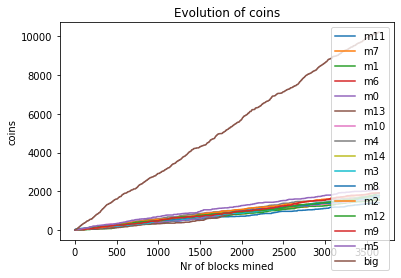

with unclerewards


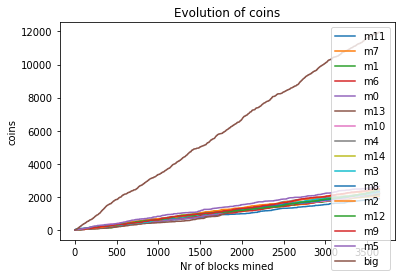

average of miners without unclereward


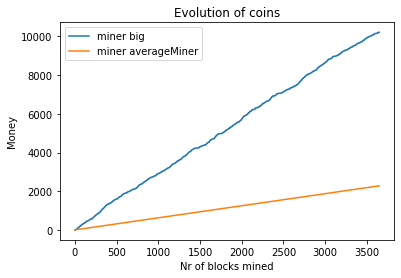

average of miners with unclereward


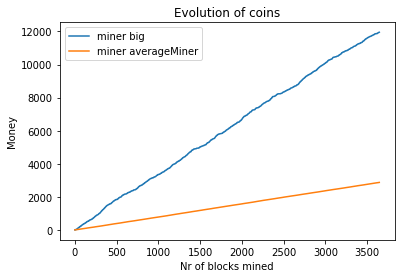

In [ ]:
#Plotting coins over time
print("Without unclerewards")
plotAllMinersOverTime(miners)
calculateUncleRewards(miners,bc)
print("with unclerewards")
plotAllMinersOverTime(miners)
removeUncleRewards(miners,bc)
print("average of miners without unclereward")
plotAverageMiners(miners)
calculateUncleRewards(miners,bc)
print("average of miners with unclereward")
plotAverageMiners(miners)
removeUncleRewards(miners, bc)

### Plotting coins of miners over time

From above we see that when plotting all honest miners the spread of each miner gets smaller. Which is also reflected in the SD that is shown below, the variation of coins rewarded is less. When compressing all miners to an average miner we see that there is not much difference in the relation between the big miner and the average miner with/without uncle reward, except an increase of money gained overall. 



In [ ]:
#Fairness analysis
VisualizeFairnessOfSystem(miners, "without")
calculateUncleRewards(miners,bc)
VisualizeFairnessOfSystem(miners, "with")
removeUncleRewards(miners,bc)

Standard deviation of fairness:  0.09576955987759693
Median fairness of system:  0.9626988480526605
Minimum fairness of system:  0.7734503565551288
Maximum fairness of system:  1.1574328030718595
average:  0.9696928140427866


Standard deviation of fairness:  0.07630746059253771
Median fairness of system:  0.9810236768802227
Minimum fairness of system:  0.8234679665738162
Maximum fairness of system:  1.149460306406685
average:  0.9899242688022284


## Uncle reward conclusion

- How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles

From the simulation above with and without calculated unclereward we can see that the average and median fairness of the system is increased with 2 percent points, and the SD is lowered with also 2 percent point. This means that the average miner will now get almost 1:1 ratio of reward based on energy spent.
In our model, any miner that mines a block will be rewarded either with block reward or uncle reward, thus no contribution is unrewarded.

*** 



#  Modelling blockchain with selfish miner and uncle rewards

In this section we implement a new type of miner, the SelfishMiner, which has a goal to withhold a successfully mined block from being published. With this unpublished block the selfish miner will continue to mine, ending up with more proof-of-work compared to other miners. This will give the selfish miner the block reward. The goal is to create a private chain, and later on reveal the chain when beneficial for the miner.



In [ ]:
class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        #self.nonce = random.randint(0,100000)
        self.reward = 0
        self.fairness = None
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height: 
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height -1 and len(self.privateBlocks) > 1:
            for block in self.privateBlocks: 
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0, self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else: 
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

def attackerHasControl(blockchain, attacker):
    if blockchain.longestChain().creator == attacker: 
        return True
    return False

# Simulation 2: What is the impact of the uncles on selfish mining? Is selfish mining more profitable with uncles?

In order to examine this question, a good place to start is to set up a simulation with a base set of nodes, and one selfish miner with the same amount of power.

Then we compare how the selfish miner competes with the normal miners.

In [ ]:

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(BASEMININGPOWER,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
prepareBlockchain(bc, miners)
visualizeRewards(miners,"without")
calculateUncleRewards(miners, bc)
visualizeRewards(miners,"with")
removeUncleRewards(miners,bc)

alpha 0.058823529411764705


### Comparison of coins rewarded

When comparing the selfish miner against the other 15 honest miners, we see that it does not perform as good as any other miner. 
Without uncle reward the average coin is 2279, but the selfish miner received 1450. 
Likewise for with uncle reward the average miner was given 2871 coins, and the selfish miner 2428. 
From these numbers, it is clearly more beneficial to be an honest miner in this model.

Without unclerewards


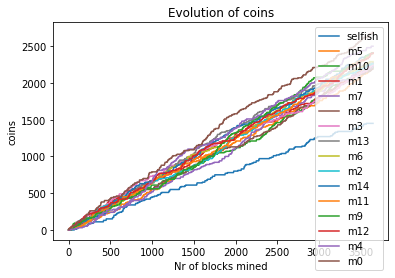

with unclerewards


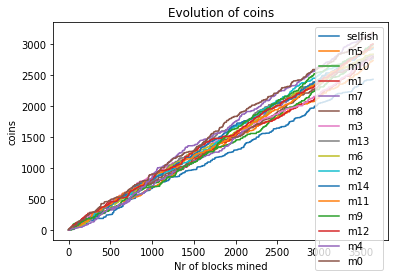

average of miners without unclereward


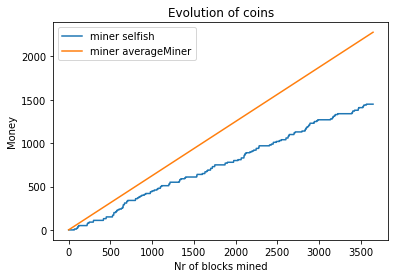

average of miners with unclereward


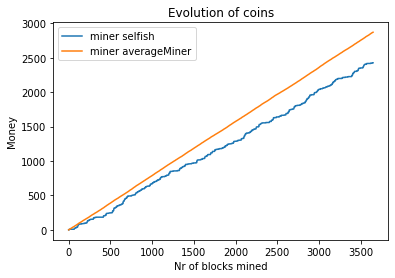

In [ ]:
#Plotting coins over time
print("Without unclerewards")
plotAllMinersOverTime(miners)
calculateUncleRewards(miners,bc)
print("with unclerewards")
plotAllMinersOverTime(miners)
removeUncleRewards(miners,bc)
print("average of miners without unclereward")
plotAverageMiners(miners)
calculateUncleRewards(miners,bc)
print("average of miners with unclereward")
plotAverageMiners(miners)
removeUncleRewards(miners, bc)

### COINS OVER TIME
What we bring with us from the previous model was that the selfish miner does not perform as good as a given honest miner. 
What the plots of coins over time shows us, is that the gap between average miner and selfish miner is drastically reduced when introducing uncle rewards.
From the first plot with average miner we see that the selfish miner is losing more and more of the reward over time. 
However, with the uncle reward the selfish miner and average miner have a similar growth in rewarded coins. Which statest that it is more beneficial for the selfish miner to mine in a system with uncle reward.

In [ ]:
#Fairness analysis
VisualizeFairnessOfSystem(miners, "without")
calculateUncleRewards(miners,bc)
VisualizeFairnessOfSystem(miners, "with")
removeUncleRewards(miners,bc)

Standard deviation of fairness:  0.10914560362899801
Median fairness of system:  0.9958870304359748
Minimum fairness of system:  0.636139292569235
Maximum fairness of system:  1.180148066904305
average:  1.0


Standard deviation of fairness:  0.06020710284523956
Median fairness of system:  0.9859602533684508
Minimum fairness of system:  0.8456063211510415
Maximum fairness of system:  1.1099453647069066
average:  1.0


## Fairness of selfish and proposed subsimulation

From the plots above, the selfish miner reported a fairness of 0.6 without uncle reward, and 0.8 with uncle reward.
The average was unchanged, but the SD was greatly reduced. We can see this from the fact that the selfish miner increases, and the miners that reported a fairness above 1.0, was decreased. 

To further test what will make the selfish mining more profitable we will give the miner more miningpower, and also include a miner that will have a miningpower equal to the selfish one.

## Sub-simulation 1: Increasing power of selfish miner

We now want to give selfish a bit more power than your average node. We also introduce a small honest miner as "big" with the same power as selfish as a reference point. 

In this simulation every node will have mining power 5, except big and selfish, which has a mining power 7. 
The difficulty of the blockchain is the same as before.
With the purpose of increasing the fairness for the selfish miner, we will only plot and discuss the outcome of the fairness.

In [ ]:
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)
big = Miner(7, "big",bc)
selfish = SelfishMiner(7,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()
    big.PoWSolver()
    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
    big.UpdateLast()
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
miners.append(big)
total = 0
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
prepareBlockchain(bc,miners)
VisualizeFairnessOfSystem(miners,"without")
calculateUncleRewards(miners,bc)
VisualizeFairnessOfSystem(miners,"with")
removeUncleRewards(miners,bc)


alpha 0.07865168539325842


Standard deviation of fairness:  0.11360751045152544
Median fairness of system:  1.0305789769533447
Minimum fairness of system:  0.6360716293262667
Maximum fairness of system:  1.150646430578977
average:  1.0050183985904648


Standard deviation of fairness:  0.06169629938154388
Median fairness of system:  1.0064884744204374
Minimum fairness of system:  0.8516826314159998
Maximum fairness of system:  1.0750684091854381
average:  1.001838765321588


## Sub-simulation 2: fairness and proposed subsimulation
In the previous simulations the selfish miner has had less than 10% of the miningpower in the network. We explore what happens when we pump that number up.

From the first plot without unclereward we notice that the both selfish and big are the ones that comes the best out of the simulation with fairness over 1.0.
However, with the unclereward, the selfish miner underperforms and falls to 0.9, and the "big" miners fairness is lowered and lands on 1.0 in fairness.


To further increase the simulation and comparison, we will increase the miningpower of the selfish miner and the honest test-miner "big" to 25.


In [ ]:
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)
big = Miner(BIGMININGPOWER, "big",bc)
selfish = SelfishMiner(BIGMININGPOWER,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()
    big.PoWSolver()
    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
    big.UpdateLast()
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
miners.append(big)
total = 0
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
prepareBlockchain(bc,miners)
VisualizeFairnessOfSystem(miners,"without")
calculateUncleRewards(miners,bc)
VisualizeFairnessOfSystem(miners,"with")
removeUncleRewards(miners,bc)


alpha 0.2


Standard deviation of fairness:  0.11760974238543115
Median fairness of system:  0.9217335058214747
Minimum fairness of system:  0.7438551099611902
Maximum fairness of system:  1.1853169469598963
average:  0.9348603607031427


Standard deviation of fairness:  0.08509545812411592
Median fairness of system:  0.981344294877586
Minimum fairness of system:  0.8204218989971994
Maximum fairness of system:  1.1423796187550816
average:  0.9668496543074724


## Selfish fairness with more miningpower
The control of the network for the selfish miner is increased from 0.07 to 0.2, which means it should be able to get more of the reward. 

Without the unclereward the selfish miner and big are both at top with fairness over 1.0.
What we see from the plot with the unclereward selfish and big switch places, but they are both top 2 on fairness.
This is quite different from what we saw when the selfish miner had 7 in miningpower.

Thus it can seem that a higher mining power percentage benefits a selfish miner more than an honest miner.

In the next subsimulation we grant the selfish miner 33% control of the network, which should give it a high advantage when collecting reward.
 

In [ ]:
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)
big = Miner(BIGMININGPOWER, "big",bc)
selfish = SelfishMiner(BIGMININGPOWER*2,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()
    big.PoWSolver()
    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
    big.UpdateLast()
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
miners.append(big)
total = 0
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
prepareBlockchain(bc,miners)
VisualizeFairnessOfSystem(miners,"without")
calculateUncleRewards(miners,bc)
VisualizeFairnessOfSystem(miners,"with")
removeUncleRewards(miners,bc)


alpha 0.3333333333333333


Standard deviation of fairness:  0.2348981560710628
Median fairness of system:  0.6514657980456026
Minimum fairness of system:  0.5320304017372421
Maximum fairness of system:  1.5808903365906624
average:  0.7208277447786933


Standard deviation of fairness:  0.13461737028954923
Median fairness of system:  0.8302340086396083
Minimum fairness of system:  0.6985608353161311
Maximum fairness of system:  1.301554667467486
average:  0.8610569455900359


## Fairness for selfish miner
Now the Big miner is given 25 miningpower, and selfish is given 50 miningpower.
This gives the selfish miner 33% of all the miningpower in the network.

In the plot without the unclereward we notice that the big miner has the advantage, with a fairness score of 1.6. Which is 60% more reward than what is fair to the others. At the same time selfish reported a fairness of 0.8.

However, with the unclereward, the selfish miner is the one who scores a fairness of 1.2, which is the highest it has reported of all the simulations.
And the big miner is lowered to almost 1.0.

So the selfish miner needed 33% of the network power to be dominate with uncle reward, otherwise a honest miner with a big miningpower would be the champion. It is important to remember that the plot plots our fairness model, and not the amount of coins a miner gets.


# Selfish mining with uncle reward conclusion

*** 

- What is the impact of the uncles on selfish mining? Is selfish mining more profitable with uncles?

What we can take with us from the simulations is that in regards to coins, selfish mining with uncle reward is more profitable versus without uncle rewards.The risk in selfish mining is the fact that the selfish miner can loose the blocks that it is keeping for itself. Resulting from the fact that they are not published in the longest chain and thus not rewarded for the energy spent to mine these blocks. While with uncles, the selfish miners will receive almost full reward, resulting in selfish mining beeing much less risky. Therefore selfish mining is more profitable with uncle rewards in regards to reward.

On the perspective of fairness, it is not identical to what a selfish miner can expect with rewards.In the basic simulation the fairness increased drastically when we added uncle reward, but it was still the lowest of all miners. When the selfish miner had 20% of the network, it was the first time it reported a fairness above 1.0 both with and without uncle reward. On the last subsimulation, when the selfish miner had double the power of big, the big reported most on the fairness scale without uncle, and selfish the most without.
To conclude, selfish is more profitable based on the energy spent as long as the selfish miner has a high enough miningpower (control of the network). Otherwise, an honest miner with higher miningpower would be the most profitable. It would also seem that a selfish miner in an uncle reward system, benefits more than an honest miner with increased control of the network. as became clear in the last subsimulation.

***

- What does it mean in this model for the selfish mining attack to be profitable?

If a selfish miner mines a block, and is not chosen to be in the longest chain. Normally the block is discarded without any reward. However with uncles, the selfish mined block will receive reward for using resources to mine a block. Therefore the selfish miner, will receive reward either if he succeeds in creating an accepted block or not. Thus selfish mining will always grant some reward from the power it used. If it's "worth the power" to be an selfish miner seems to come down to the amount of control you have over the network. As mentioned it was only with a large enough power that the selfish mining is ensured to be more profitable than honest miners,thus the attack is only profitable if the miner has enough control of the network.

# Implementing UncleMiner
To further this project we created an uncleminer. The uncleminer does not want a block in the longest chain, he searches for uncle rewards.  The uncleminer will start by working on the genesis block as everyone else. Should a block be published he will keep mining his block. And he will not give up until he mines a block. He then publish the block to get his unclereward. Afterwards he starts to mine on the parent of the block that is the longest chain-block. 

The key idea here is that an UncleMiner stores the nonce that are used and will not use the same nonces when still mining on the same block, thus hopefully grants him more rewards as he is working with the same block and does not need to update blocks to the newest all the time.


The main difference in the implementation is in the POW. Where he only calls updateLast() when he finds and publishes a block. He also start to work on the parent of the latest block, not the latest itself.



In [ ]:
class UncleMiner:
    def __init__(self, miningPower, name, blockchain=None):
        self.reward = 0 # added reward attribute
        self.miningPower = miningPower
        self.fairness = None
        self.nonce = random.randint(0,100000)
        self.usedNonce= []
        self.name = name
        self.coins = []
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()

    
    def UpdateLast(self):
        latest = self.blockchain.longestChain()  
        if latest.previous != None:
            blockToMine = latest.previous
        self.lastBlock = blockToMine
         
    
    def PoWSolver(self):
        for i in range(0, self.miningPower):
            nonce = self.nonce
            while nonce in self.usedNonce:
                nonce = self.nonce
            self.usedNonce.append(nonce)
            
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
                self.MinedLastBlock = True
                self.usedNonce = []
                self.UpdateLast()
            self.nonce += 1


# Simulation 3: UncleMiner

In this simulation we want to see how an uncleminer compares against his fellow miners. The base simulation being 15 miners and him. All with the same miningpower. in the following simulations we print out the number of uncleblocks in a system as that can be quite important for the uncleminer.

In [ ]:

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

uncleMiner = UncleMiner(BASEMININGPOWER,"uncleMiner", bc)

while bc.size < BLOCKCHAINSIZE: 
    uncleMiner.PoWSolver()
    
    for m in miners: 
        m.PoWSolver()

    
    for m in miners: 
        m.UpdateLast()

miners.append(uncleMiner)

''' total = 0
for m in miners: 
    total += m.miningPower '''
prepareBlockchain(bc, miners)
visualizeRewards(miners,"without")
calculateUncleRewards(miners, bc)
visualizeRewards(miners,"with")
print(len(bc.uncleBlocks))

removeUncleRewards(miners,bc)


1339


## uncleMiner basic simulation

As expected from our implementation, the simulation without unclerewards will not give any reward to the uncleMiner. He will only mine the uncleblocks, but will receive no reward.
When we introduce the reward scheme, we see that the uncleminer did receive coins, but only half of what the worst honest miner got. In this simulation out of 5000 blocks, 1339 where uncleblocks and did not get to be on the mainchain.

## Additional simulations with uncleMiner

In the previous we had a base difficulty of 7. As uncleminer is dependent on forks we are interested to see how a change in difficulty of the network will affect him. the idea beeing that a lower difficulty will result in more forks and thus more unclerewards. Thus we run two additional experiments where we increase and decrease the difficulty.  

### Sub-simulation 1: Lower difficulty

In [ ]:

bc = Blockchain("0", 3)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

uncleMiner = UncleMiner(BASEMININGPOWER,"uncleMiner", bc)

while bc.size < BLOCKCHAINSIZE: 
    uncleMiner.PoWSolver()
    
    for m in miners: 
        m.PoWSolver()

    for m in miners: 
        m.UpdateLast()

miners.append(uncleMiner)

prepareBlockchain(bc, miners)
visualizeRewards(miners,"without")
calculateUncleRewards(miners, bc)
visualizeRewards(miners,"with")
print(len(bc.uncleBlocks))

removeUncleRewards(miners,bc)



3988


## uncleMiner with low difficulty

When we lower the difficulty the amount rewarded both total and average are heavily lowered. But the amount of uncleblocks are doubled up to almost 4000 of 5000 blocks. However the uncleminer was unable to profit more than an honest miner in this scenario.
Now we will increase the difficulty of the blockchain to 10, and see how this affects the uncleMiner.

In [ ]:

bc = Blockchain("0", 10)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

uncleMiner = UncleMiner(BASEMININGPOWER,"uncleMiner", bc)

while bc.size < BLOCKCHAINSIZE: 
    uncleMiner.PoWSolver()
    
    for m in miners: 
        m.PoWSolver()

    for m in miners: 
        m.UpdateLast()

miners.append(uncleMiner)

prepareBlockchain(bc, miners)
visualizeRewards(miners,"without")
calculateUncleRewards(miners, bc)
visualizeRewards(miners,"with")
print(len(bc.uncleBlocks))
removeUncleRewards(miners,bc)



436


## uncleMiner with high difficulty

The total amount handed out is quite high compared to the other simulations. But the most intersting factor is that there is barely a difference between the total amount and average coins handed out are minimal. 
Somehow, the amount of coins that uncleMiner was given is very similar to the other simulations. 

Also in this simulation the number of uncle blocks generated was less than 500, which describes why the difference between the system with/without unclereward is low.

## Conclusion
Overall the uncleMiner does not fare well in comparison to the other honest miners. uncleMiner received the most amount of coins when the difficulty was lower (and the number of uncleblocks was large), but was always given the least of all miners. It was also not such a huge difference even though the number of uncleblocks varied greatly. 
The uncleMiner might get the upperhand if he had more miningpower, but he would then just be a "big" miner with less possibilities of receiving reward.
Thus, it seems that the uncleMiner is not very efficient and the honest miners are more profitable.

# Simulation 4: Plotting wrong values
In this setup we explore how "wrong" values affect the blockchain and fairness. This is to see if the basic reward scheme is the best, or if there is another combination of the basic numbers that yield a higher volume of fairness. We will not edit the numbers (2,5,10), because it would take a lot of time and simulation to find 3 numbers that would be the "perfect" scheme. For comparison we will also include a selfishMiner and uncleMiner.

First off we will give UncleReward the most, Block second most, and nephew reward the same.
### Uncle: 10, Neph: 2, Block: 5

alpha 0.058823529411764705
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.08846992019366733
Median fairness of system:  1.0328180092215895
Minimum fairness of system:  0.7116897206400868
Maximum fairness of system:  1.0718741524274478
average:  1.0
bc.size:  5000
bc.uncle:  1313
bc.mainchainlenght:  3688
percentage of forks:  35.60195227765727
Plotting all miners against eachother without unclereward


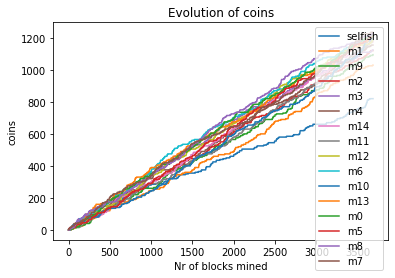

visualizes average miners vs deviant miners without unclereward


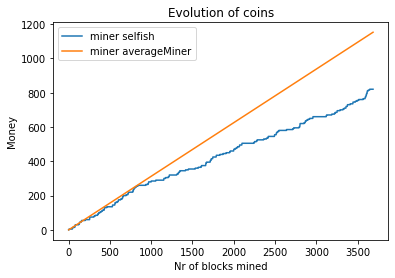

Plotting all miners against eachother with unclereward


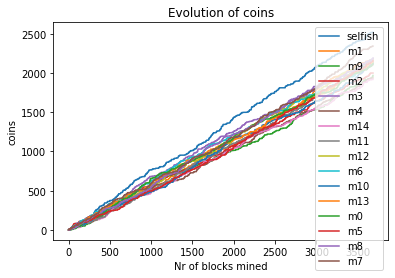

visualizes average miners vs deviant miners with unclereward


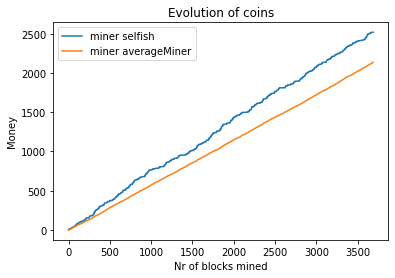

Standard deviation of fairness:  0.06752280217509364
Median fairness of system:  1.0011991459740868
Minimum fairness of system:  0.8980140972770612
Maximum fairness of system:  1.1792576993945776
average:  1.0
bc.size:  5000
bc.uncle:  1313
bc.mainchainlenght:  3688
percentage of forks:  35.60195227765727
percentage of forks:  None


In [ ]:
BASEREWARD = 5
UNCLEREWARD = 10
NEPHEWREWARD = 2
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(BASEMININGPOWER,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

# Analysis of wrong values 
## Uncle has the highest reward
For comparison the default reward scheme gave us:
#### without uncle reward
SD: 0.09
Median: 0.96
Average: 0.96

#### with uncle reward
SD: 0.07
Median: 0.98
Average: 0.98

Surprisingly, the simulation without unclereward was very similar to the base reward system. And this simulation with uncle reward reported SD of 0.06, median of 1.00 and average of 1.00. This is the best score reported so far of all simulations. 

An additional thing to consider is the selfish miner, where without unclerewards he laggs behind his fellow miners alot. but granting him increaserd unclereward he outperforms all the other miners. Going from last place to first place in both fairness and coins recieved. 

We will now give the nephew the most reward, uncle second most and block the least. 

### Uncle: 5, Neph: 10, Block: 2


alpha 0.058823529411764705
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.08252274217157687
Median fairness of system:  1.0090287277701777
Minimum fairness of system:  0.7441860465116279
Maximum fairness of system:  1.1119015047879617
average:  1.0
bc.size:  5000
bc.uncle:  1345
bc.mainchainlenght:  3656
percentage of forks:  36.788840262582056
Plotting all miners against eachother without unclereward


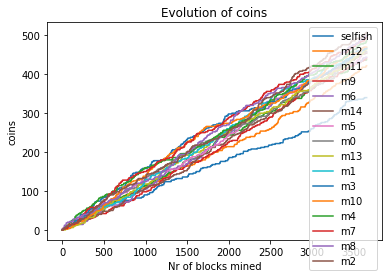

visualizes average miners vs deviant miners without unclereward


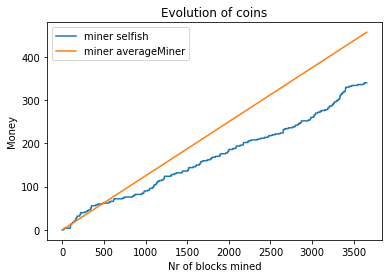

Plotting all miners against eachother with unclereward


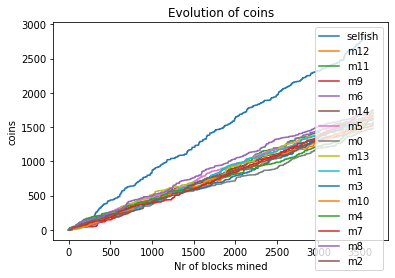

visualizes average miners vs deviant miners with unclereward


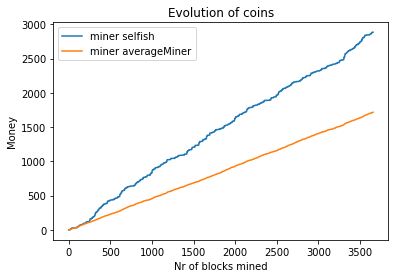

Standard deviation of fairness:  0.1805042253896749
Median fairness of system:  0.9686738220847735
Minimum fairness of system:  0.8633072585046389
Maximum fairness of system:  1.6794615244678917
average:  0.9999999999999999
bc.size:  5000
bc.uncle:  1345
bc.mainchainlenght:  3656
percentage of forks:  36.788840262582056
percentage of forks:  None


In [ ]:
BASEREWARD = 2
UNCLEREWARD = 5
NEPHEWREWARD = 10
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(BASEMININGPOWER,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

## Nephew the highest reward

Based on the fact that most miners get the base reward, it is not surprising to see that the SD is very high (0.18) and coins handed out are very low compared to the others. This is not a desirable scheme, because the miners would like to get a high reward for all their power spent.

Since one of the earlier ones performed better than the base one, we will swap the value for nephew and block reward and see if this can be the best one.

Also here we see that the selfish miner goes from a last place to a first place in both categories just by introducing uncle rewards. 

### Uncle: 10, Neph: 5, Block: 2


alpha 0.058823529411764705
Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.12785885841045314
Median fairness of system:  0.9906232763375621
Minimum fairness of system:  0.6309983452840596
Maximum fairness of system:  1.2002206287920574
average:  1.0
bc.size:  5000
bc.uncle:  1374
bc.mainchainlenght:  3627
percentage of forks:  37.882547559966916
Plotting all miners against eachother without unclereward


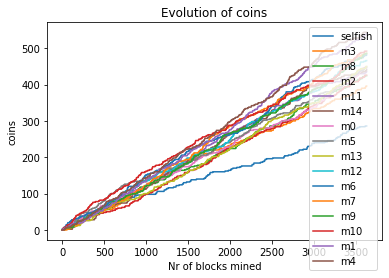

visualizes average miners vs deviant miners without unclereward


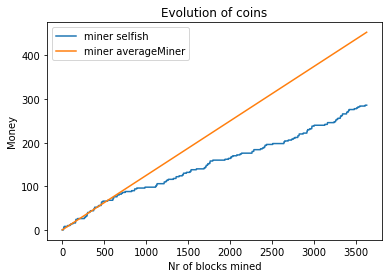

Plotting all miners against eachother with unclereward


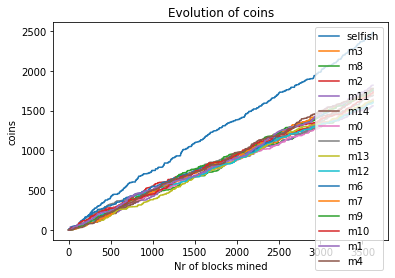

visualizes average miners vs deviant miners with unclereward


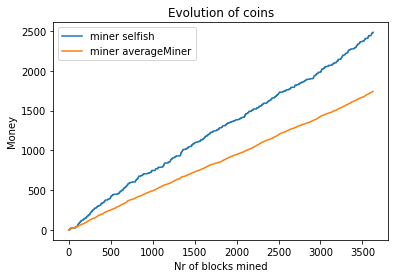

Standard deviation of fairness:  0.11786861746291086
Median fairness of system:  0.9788242050104085
Minimum fairness of system:  0.8964180604407437
Maximum fairness of system:  1.4276074940779557
average:  1.0
bc.size:  5000
bc.uncle:  1374
bc.mainchainlenght:  3627
percentage of forks:  37.882547559966916
percentage of forks:  None


In [ ]:
BASEREWARD = 2
UNCLEREWARD = 10
NEPHEWREWARD = 5
bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(BASEMININGPOWER,"selfish", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
analyzeBlockchain(miners,bc)

## Conclusion to different rewards

From comparing three different reward weightings for block, uncle and nephew

Option 1: Uncle: 5, Nephew: 2, Block: 10 (Standard reward mechanism for this project)


Option 2: Uncle 10, Nephew: 2, Block: 5


Option 3: Uncle: 5, Nephew: 10, Block: 2

From before option 1 is the default reward system for our simulations.
When comparing the fairness of the options, the basic one was the best. However, option 2 was very similar in fairness.
Thus we also wanted to test a fourth option.

Option 4: Uncle 10, Nephew: 5, Block: 2.


From all our simulations we found that option 2 was the best, but we feel like more testing must be done before this can be used as the standard one. 
And even though this was best on paper, we can quite clearly see that this would be a blockchain where forks is the desired way of getting most rewards out of the system. 

It is quite interesting to note that the selfish miner got such a boost by introducing the uncle and nephew rewards. And that even though the values are "wrong" this is an argument that the selfish miner can operate in many environments with many types of reward systems. 


## Simulation 5: BIG vs Uncle Vs Selfish Vs Average miner
For our final experiment we wanted to combine everyone to see how they perform against eachother in a system with just too many factors in play. The experiment is to simulate and compare the Big miner, uncleMiner, SelfishMiner and the average of miners to see the performance of all of them in one system.

Rewards given to miners without uncle as well as fairness of the system


Standard deviation of fairness:  0.26940101227005864
Median fairness of system:  1.0113432835820895
Minimum fairness of system:  0.0
Maximum fairness of system:  1.2805970149253731
average:  0.9376451077943615
bc.size:  5000
bc.uncle:  1650
bc.mainchainlenght:  3351
percentage of forks:  49.23903312444047
Plotting all miners against eachother without unclereward


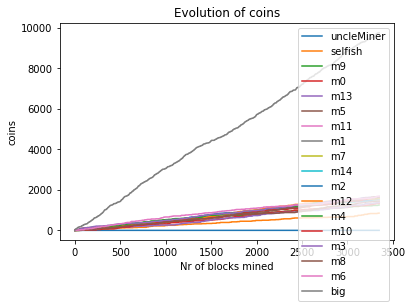

visualizes average miners vs deviant miners without unclereward


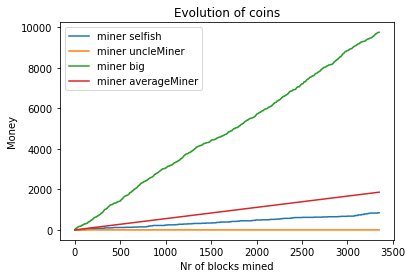

Plotting all miners against eachother with unclereward


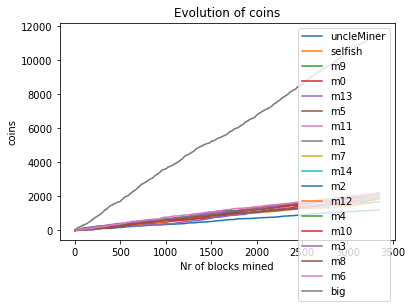

visualizes average miners vs deviant miners with unclereward


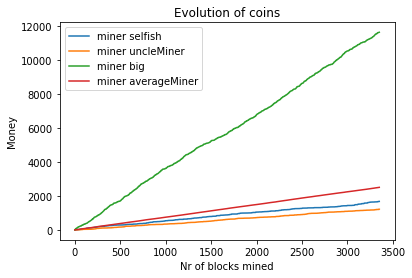

Standard deviation of fairness:  0.12299162045842149
Median fairness of system:  0.9915871254162042
Minimum fairness of system:  0.5933407325194229
Maximum fairness of system:  1.1351120976692564
average:  0.969975089406832
bc.size:  5000
bc.uncle:  1650
bc.mainchainlenght:  3351
percentage of forks:  49.23903312444047
percentage of forks:  None


In [ ]:
BASEREWARD = 10
UNCLEREWARD = 5
NEPHEWREWARD = 2

bc = Blockchain("0", BASEDIFFICULTY)
miners = []
for i in range(BASENUMBEROFMINERS):
    m = Miner(BASEMININGPOWER, "m"+str(i), bc)
    miners.append(m)
selfish = SelfishMiner(BASEMININGPOWER,"selfish", bc)
big = Miner(BIGMININGPOWER, "big", bc)
uncleMiner = UncleMiner(BASEMININGPOWER,"uncleMiner", bc)
while bc.size < BLOCKCHAINSIZE:
    selfish.PoWSolver()
    for m in miners:
        m.PoWSolver()
    big.PoWSolver()
    uncleMiner.PoWSolver()
    
    selfish.UpdateLast()
    for m in miners:
        m.UpdateLast()
    big.UpdateLast()
    uncleMiner.UpdateLast()

miners.append(selfish)
miners.append(big)
miners.append(uncleMiner)
analyzeBlockchain(miners,bc)

## Simulation 5 comparison

#### Without uncle reward:
Big reported the most fairness, selfish the second least, and of course uncleMiner the least.
The selfish receives the least amount of money(except for uncleMiner), the average miner performs better than this, and big crushes the numbers.

##### With uncle reward:
When we include the uncle reward we see that Big has a fairness just above 1, selfish has 0.8 and uncleMiner 0.6.
The amount of coins gathered are also highly unfair as the Big miners receives most of the coins in the system.
Therefore if all these miners were in a system together, the Big miner would have the best advantage and receive most of the coins.

We can conclude that having so many miners in a system where the selfish is not the dominant mining power destroys its potential income. We can also see that uncleminer performs as poorly in this system as it has in other systems. There are just too many factors to get a good reading of this experiment, but its interesting too see that big does better in regards to fairness. And thus in our experiment the defining factor seems to be the amount of power you have, not neccesarily the type of miner you are. 

# Project conclusion

To conclude our project we would like to summarize the three questions that are the reason for this project.

##### * How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles
We noticed an increase in median and average fairness as well as a decrease in standard deviation in all our simulations with unclereward. Based on our definition of fairness it is safe to say that uncle and nephew reward increase fairness.

##### * What is the impact of the uncles on selfish mining? Is selfish mining more profitable with uncles?
Uncle reward in selfish mining decreases risk for the selfish miner thus making it more profitable for a selfish miner to mine in a uncle reward system than a system without uncle reward. We can conclude that selfish mining is more profitable with uncles but that does not neccesary mean that selfish mining is the most profitable strategy. 

##### * What does it mean in this model for the selfish mining attack to be profitable?
In this project we can say that selfish mining is profitable if the selfish mining algorithm grants the miner more money than an honest miner with the same setting. We noticed in the sub simulations of simulation 2 that in order for the selfish miner to earn more fairness than a big miner he needed around 33 % of total mining power in the system. Anything under that and he was not a clear winner in regards to fariness. Under 33 % he was either equal or less than the big miner in terms of fairness. 

##### Uncleminer
We also created our own uncleminer which unfortunately did not fare well in these simulations. When we had no unclerewards he was logically enough not able to earn any rewards. But even though we had unclerewards, increased forks in the network and wrong values, we couldn't find a single scenario where uncleminer was able to get on top (or not the bottom for that sake).

A key idea in the uncleminer was that he should be able to earn blocks faster as he is not forced to switch to the latest block each time a block is mined. And thus he would gain more uncleblocks this way. This was solved by him storing the nonce thus making sure he never used the same nonce twice. A key problem here is that the amount of possible nonces in the simulation was so large that it was unlikely any miner tried the same nonce more than once. And thus another simulation where the nonce on pow is different might have helped the uncleminer along.

In this simulation however, he struggled at every simulation. We can summarize our uncleminer experience like this: "Early bird gets the worm, and the uncleminer always sleeps until midday".

##### Wrong values
The wrong values gave us better fairness attributes when uncleminer and nephew rewards was highest, which is a problem in itself. This would mean that miners would want to fork and not work on the longest chain as this would be more profitable, so that would have been interesting to see how an uncleminer would work in that environment. It was also interesting to see that selfish went from underperfoming to outperforming in these sub simulations, when including the unclerewards.

##### Big, uncle, average and selfish
In this simuluation we just did a mashup and found that unsurprisingly uncleminer was at the bottom. In addition we saw that selfish miners struggled when he was not the one with the highest mining power. And thus a big miner can be seen to hinder a selfish miner more than a regular miner.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51d2b37e-f5c9-4678-b64c-8d73772a3321' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>